<a href="https://colab.research.google.com/github/Keekit/checkpoint/blob/main/K%C3%A9vinCorreia_Data_Checkpoint_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The durations are indicative and obviously depend on each person. If you see that you can't finish an exercise in time, don't hesitate to move to the next exercise.

If you don't have time to finish everything, you can start again this weekend or next week. You will simply indicate in the comments the scripts you have completed afterwards.

# Part 1 - API - around 1h

The following dataset lists a selection of the best restaurants in Paris, at very affordable prices (less than 15 euros per menu on average).
You will use this  [API](https://adresse.data.gouv.fr/api-doc/adresse), to retrieve coordinate points (lon, lat) for each restaurants.



In [ ]:
import pandas as pd

food_paris = pd.read_csv("https://raw.githubusercontent.com/WildCodeSchool/wilddata/main/food.csv").drop(columns = "Unnamed: 0")

In [ ]:
food_paris.head()

,nom,adresse,code postal
0,Kodawari Tsukiji,12 Rue de Richelieu,75001 Paris
1,Café Lai’Tcha,7 Rue du Jour,75001 Paris
2,Pizz'Aria,55 Rue Montmartre,75002 Paris
3,M La Vie,85 Rue Montmartre,75002 Paris
4,Road Trip,36 Rue Poissonnière,75002 Paris


In [ ]:
# Séparer la colonne 'code postal' en deux colonnes 'code_postal' et 'ville'
food_paris[['code_postal', 'ville']] = food_paris['code postal'].str.split(' ', expand=True)


In [ ]:
food_paris.head()

,nom,adresse,code postal,code_postal,ville
0,Kodawari Tsukiji,12 Rue de Richelieu,75001 Paris,75001,Paris
1,Café Lai’Tcha,7 Rue du Jour,75001 Paris,75001,Paris
2,Pizz'Aria,55 Rue Montmartre,75002 Paris,75002,Paris
3,M La Vie,85 Rue Montmartre,75002 Paris,75002,Paris
4,Road Trip,36 Rue Poissonnière,75002 Paris,75002,Paris


In [ ]:
food_paris.drop(columns = "code postal", inplace = True)

In [ ]:
food_paris.head()

,nom,adresse,code_postal,ville
0,Kodawari Tsukiji,12 Rue de Richelieu,75001,Paris
1,Café Lai’Tcha,7 Rue du Jour,75001,Paris
2,Pizz'Aria,55 Rue Montmartre,75002,Paris
3,M La Vie,85 Rue Montmartre,75002,Paris
4,Road Trip,36 Rue Poissonnière,75002,Paris


In [ ]:
# fonction pour recuperer chaque url pour chaque restaurant
def url(adresse, code_postal):
    link_main = 'https://api-adresse.data.gouv.fr/search/?q='
    link_adresse = adresse.replace(" ", "+")
    link_code = f"&postcode={code_postal}"
    link_api = link_main + link_adresse + link_code
    return link_api

# Appliquer la fonction à chaque ligne du DataFrame
food_paris['url'] = food_paris.apply(lambda row: url(row['adresse'], row['code_postal']), axis=1)



In [ ]:
import requests

coordonnees = []

for url in food_paris['url']:
  r = requests.get(url).json()
  point = r['features'][0]['geometry']['coordinates'][::-1]
  coordonnees.append(point)


In [ ]:
food_paris['coordonnees'] = coordonnees
food_paris.head()

,nom,adresse,code_postal,ville,url,coordonnees
0,Kodawari Tsukiji,12 Rue de Richelieu,75001,Paris,https://api-adresse.data.gouv.fr/search/?q=12+...,"[48.864374, 2.336258]"
1,Café Lai’Tcha,7 Rue du Jour,75001,Paris,https://api-adresse.data.gouv.fr/search/?q=7+R...,"[48.86355, 2.344247]"
2,Pizz'Aria,55 Rue Montmartre,75002,Paris,https://api-adresse.data.gouv.fr/search/?q=55+...,"[48.865983, 2.344484]"
3,M La Vie,85 Rue Montmartre,75002,Paris,https://api-adresse.data.gouv.fr/search/?q=85+...,"[48.867596, 2.343757]"
4,Road Trip,36 Rue Poissonnière,75002,Paris,https://api-adresse.data.gouv.fr/search/?q=36+...,"[48.869951, 2.34794]"


# Folium

You will now project these restaurants on a map, using the `Folium` library.

In [ ]:
import folium
m = folium.Map(location=food_paris['coordonnees'][0],zoom_start=13)



for indew, row in food_paris.iterrows():
  folium.Marker(
    location=row['coordonnees'],
    popup=row['nom']
    ).add_to(m)
m

# Sorting and grouping

You can now build a descending ranking,  considering the number of restaurants per district.

In [ ]:
# Extraire l'arrondissement du code postal (deux derniers chiffres)
food_paris['arrondissement'] = food_paris['code_postal'].str[-2:]

In [ ]:
food_paris.head()

,nom,adresse,code_postal,ville,url,coordonnees,arrondissement
0,Kodawari Tsukiji,12 Rue de Richelieu,75001,Paris,https://api-adresse.data.gouv.fr/search/?q=12+...,"[48.864374, 2.336258]",01
1,Café Lai’Tcha,7 Rue du Jour,75001,Paris,https://api-adresse.data.gouv.fr/search/?q=7+R...,"[48.86355, 2.344247]",01
2,Pizz'Aria,55 Rue Montmartre,75002,Paris,https://api-adresse.data.gouv.fr/search/?q=55+...,"[48.865983, 2.344484]",02
3,M La Vie,85 Rue Montmartre,75002,Paris,https://api-adresse.data.gouv.fr/search/?q=85+...,"[48.867596, 2.343757]",02
4,Road Trip,36 Rue Poissonnière,75002,Paris,https://api-adresse.data.gouv.fr/search/?q=36+...,"[48.869951, 2.34794]",02


In [ ]:

# Compter le nombre de restaurants par arrondissement
arrondissement_count = food_paris['arrondissement'].value_counts().reset_index()
arrondissement_count.columns = ['arrondissement', 'nombre_restaurants']
arrondissement_count.index += 1  # Commencer l'index à 1


# Trier les arrondissements par ordre décroissant du nombre de restaurants
arrondissement_count = arrondissement_count.sort_values(by='nombre_restaurants', ascending=False)

In [ ]:
arrondissement_count

,arrondissement,nombre_restaurants
1,02,5
2,09,4
3,10,4
4,11,3
5,01,2
6,03,2
7,04,2
8,06,2
9,08,2
10,07,1


# Part 2 - Data exploration & processing - Python & Pandas - around 30 min

Run the code below. You will get a DataFrame with 10 000 restaurant comments.
- date: the date of the comment
- stars: the rating (from 1 to 5)
- text: the text of the review
- useful: the number of users who indicated this comment as "useful"
- sentiment: the word "good" or "bad" depending on the stars rating

The goal of these parts will be to explore this dataset, then to propose a prediction model of positive rating according to the other features.

Start by checking that there are no missing values.

In [ ]:
import pandas as pd
df_restaurants = pd.read_csv("https://github.com/WildCodeSchool/wilddata/raw/main/restaurant.zip", index_col='Unnamed: 0').loc[:,["date", "stars", "text", "useful"]]
df_restaurants["sentiment"] = df_restaurants["stars"].apply(lambda x: "bad" if x <=3 else "good")
df_restaurants

,date,stars,text,useful,sentiment
0,2011-01-26,5,My wife took me here on my birthday for breakf...,5,good
1,2011-07-27,5,I have no idea why some people give bad review...,0,good
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,1,good
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",2,good
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,good
...,...,...,...,...,...
9995,2012-07-28,3,First visit...Had lunch here today - used my G...,2,bad
9996,2012-01-18,4,Should be called house of deliciousness!\n\nI ...,0,good
9997,2010-11-16,4,I recently visited Olive and Ivy for business ...,0,good
9998,2012-12-02,2,My nephew just moved to Scottsdale recently so...,0,bad


In [ ]:
df_restaurants.isna().sum()

date         0
stars        0
text         0
useful       0
sentiment    0
dtype: int64

In [ ]:
df_restaurants.duplicated().sum()

1

In [ ]:
df_restaurants[df_restaurants.duplicated()]

,date,stars,text,useful,sentiment
9680,2012-06-16,2,This review is for the chain in general. The l...,0,bad


In [ ]:
df_restaurants = df_restaurants.drop_duplicates()

## Column "text"

Use **apply** to create a new column `len_text`, indicating the length (number of characters) of each comment.

Draw a histogram and a boxplot to represent the distribution of this "len_text" column. Are the values well distributed? Are most comments long or short?

In [ ]:
df_restaurants['len_text'] = df_restaurants['text'].apply(len)

In [ ]:
df_restaurants.head()

,date,stars,text,useful,sentiment,len_text
0,2011-01-26,5,My wife took me here on my birthday for breakf...,5,good,889
1,2011-07-27,5,I have no idea why some people give bad review...,0,good,1345
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,1,good,76
3,2010-05-27,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",2,good,419
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,good,469


In [ ]:
df_restaurants['useful'].unique()

array([ 5,  0,  1,  2,  3,  7,  4,  6, 16,  9, 17, 19, 28,  8, 15, 10, 12,
       23, 20, 11, 13, 18, 14, 24, 76, 31, 38, 30])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

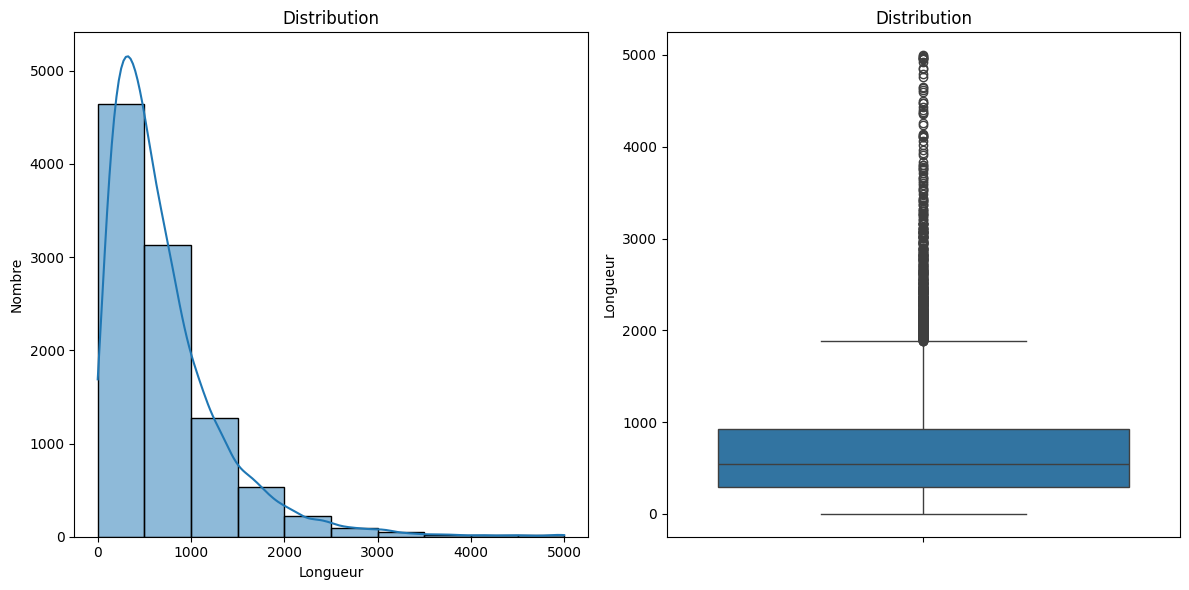

In [ ]:
plt.figure(figsize=(12, 6))


# Histogramme de la distribution de len_text
plt.subplot(1, 2, 1)
sns.histplot(df_restaurants['len_text'], bins=10, kde=True)
plt.title('Distribution')
plt.xlabel('Longueur')
plt.ylabel('Nombre')

# Boxplot de la distribution de len_text
plt.subplot(1, 2, 2)
sns.boxplot(y=df_restaurants['len_text'])
plt.title('Distribution')
plt.ylabel('Longueur')

plt.tight_layout()
plt.show()

In [ ]:
''' Grâce aux deux graphiques nous pouvons constater que plus de 75% des commentaires
    font moins de 1000 characteres.
    Il y a tres peu de commentaires longs ou très longs, la majorité sont courts, inferieurs à 500 caracteres.
    Il y a cependant des valeurs tres hautes, qui correspondent a des commentaires detaillés,
    mais ceux ci sont rares ou exceptionnels.
'''

' Grâce aux deux graphiques nous pouvons constater que plus de 75% des commentaires\n    font moins de 1000 characteres.\n    Il y a tres peu de commentaires longs ou très longs, la majorité sont courts, inferieurs à 500 caracteres.\n    Il y a cependant des valeurs tres hautes, qui correspondent a des commentaires detaillés,\n    mais ceux ci sont rares ou exceptionnels.\n'

## Column "stars"

- Draw a scatterplot to compare the `useful` column and the `stars` column. Do you think there is a correlation? Please compute the correlation coefficient.

- Ditto between `len_text` and `useful`.

- Please comment and interpret the results.



<Axes: xlabel='stars', ylabel='useful'>

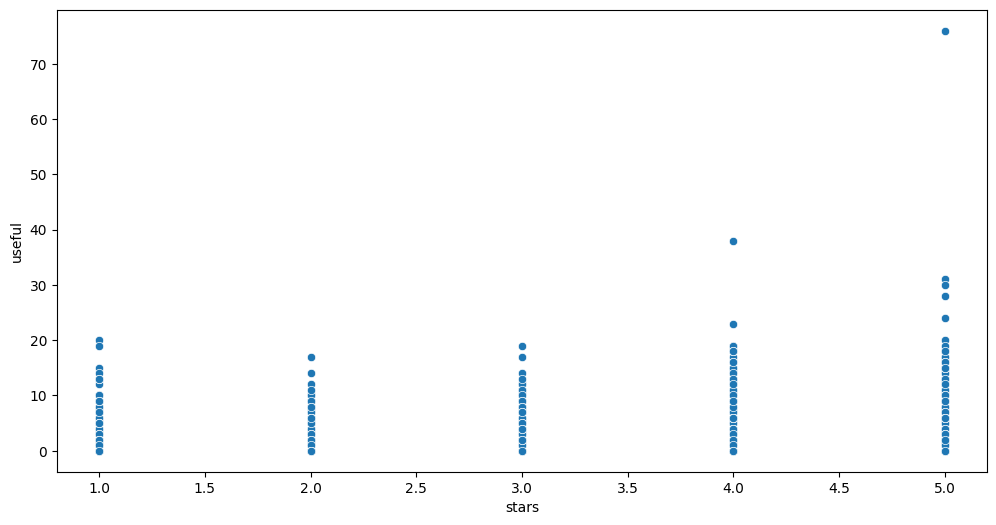

In [ ]:
plt.figure(figsize=(12, 6))

# Scatterplot de useful en fonction de stars
sns.scatterplot(x='stars', y='useful', data=df_restaurants)

In [ ]:
correlation_stars_useful = df_restaurants['stars'].corr(df_restaurants['useful'])
correlation_stars_useful

-0.023478955127693917

In [ ]:
''' Il n'y pas de corrélation entre la note attribuée et l'utilité du commentaire.
    Cela est logique dans l'idée ou les commentaires positifs sont autant utiles que
    les commentaires négatifs pour l'utilisateur
'''

<Axes: xlabel='len_text', ylabel='useful'>

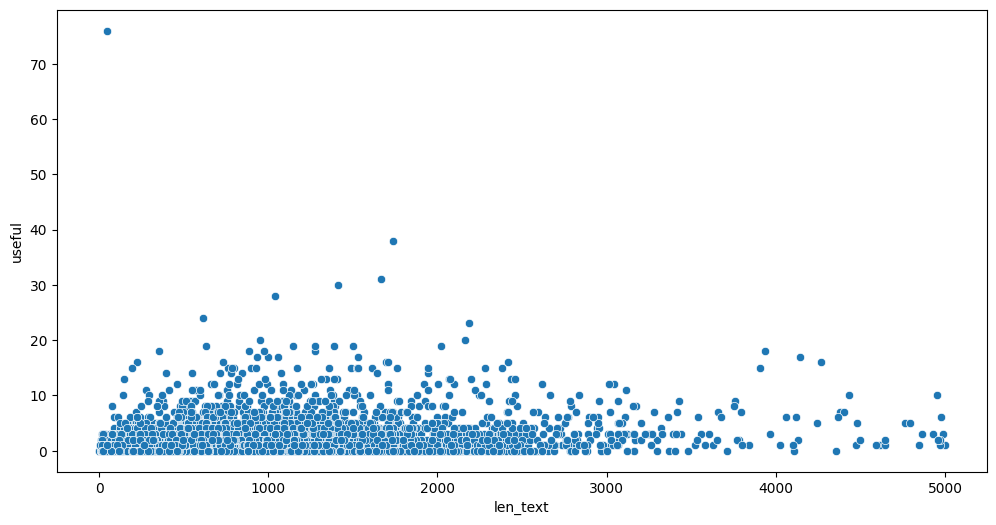

In [ ]:
plt.figure(figsize=(12, 6))

# Scatterplot de useful en fonction de len_text
sns.scatterplot(x='len_text', y='useful', data=df_restaurants)

In [ ]:
correlation_len_text_useful = df_restaurants['len_text'].corr(df_restaurants['useful'])
correlation_len_text_useful

0.29397538215526103

In [ ]:
''' On peut dire qu'il y a une faible corrélation positive entre la taille d'un commentaire
    et son utilité. Cependant la taille d'un commentaire ne peux expliquer a lui seul l'utilité
    pour le client; en effet il peut aussi bien avoir des commentaires courts utiles que des commentaires long utiles.
    Et l'inverse est aussi vrai.
    Au vu de la concentration des points nous pouvons voir que les commentaires entre 500 et 2000 caracteres
    sont les plus utiles.
    On peut deduire que les commentaires doivent en general presenter un minimum de caracteres et donc d'informations
    pour etre utiles.
'''

# Part 3 : NLP - Sentiment analysis classification - 2h

Define `X` which will contain only the `text` column. And `y` will be the `sentiment` column.

In [ ]:
X = df_restaurants['text']
y = df_restaurants['sentiment']

## Create a function to clean up stopwords and punctuation

You can call your function `func_clean`.
Your function must take a `str` as a single parameter, and return a `str`.

For example:

`func_clean("Hello, how are you? Fine, thank you.")`

`>>> 'hello fine thank'`

## Apply this function

Apply this function to `X` and store the result in `X_clean`.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def func_clean(str):
    # Tokenisation et conversion en minuscules
    tokens = nltk.word_tokenize(str.lower())
    # Liste des stopword en anglais
    stop_words = set(stopwords.words('english'))
    # Filtrage
    tokens_clean = [word for word in tokens if word not in stop_words]
    # Suppression des ponctuations
    tokens_clean = [word for word in tokens_clean if word.isalnum()]
    # Retourner une chaîne de caractères
    cleaned_sentence = ' '.join(tokens_clean)
    return cleaned_sentence

In [ ]:
func_clean("Hello, how are you? Fine, thank you.")

'hello fine thank'

In [ ]:
X_clean = X.apply(func_clean)

## Train test split

Split your `X_clean` and `y` data with a train test split, and the same `random_state = 32`.



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=32)

## TfidfVectorizer

- Train `TfidfVectorizer` on `X_train`.
- Transform `X_train` with your vectorizer and store the result in `X_train_vecto`.
- Transform `X_test` with your vectorizer and store the result in `X_test_vecto`.

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

X_train_vecto = tfidf.fit_transform(X_train) # entraine et cree la matrice
X_test_vecto = tfidf.transform(X_test) # matrice sans re-entrainer le model (garde le fit de train)

## Logistic regression

Train a logistic regression on `X_train_vecto` and `y_train`.

Please compare the accuracy scores of the training and test sets. Is there any overfitting?

Also display a confusion matrix for the test set. How many "bad" comments are correctly predicted?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
lrm = LogisticRegression()
lrm.fit(X_train_vecto, y_train)

train_score = lrm.score(X_train_vecto, y_train)
test_score = lrm.score(X_test_vecto, y_test)

print(train_score)
print(test_score)

0.893875
0.832


In [ ]:
'''   Autre méthode avec accuracy_score
      Ce sont les mêmes résultats
'''

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# predictions
y_train_pred = lrm.predict(X_train_vecto)
y_test_pred = lrm.predict(X_test_vecto)

# calcul avec accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(train_accuracy)
print(test_accuracy)

0.893875
0.832


In [ ]:
'''   L'overfitting se produit lorsque le modèle performe significativement
      mieux sur les données d'entraînement par rapport aux données de test, ce qui
      indique qu'il a appris des détails spécifiques et du bruit provenant de l'ensemble
      d'entraînement qui ne se généralisent pas bien.
      Ici la précision sur l'ensemble d'entraînement (89,39 %) est supérieure à celle de
      l'ensemble de test (83,20 %).
      Il y a donc bien un leger overfitting dans notre modèle. Cependant il n'est pas
      très important.
'''

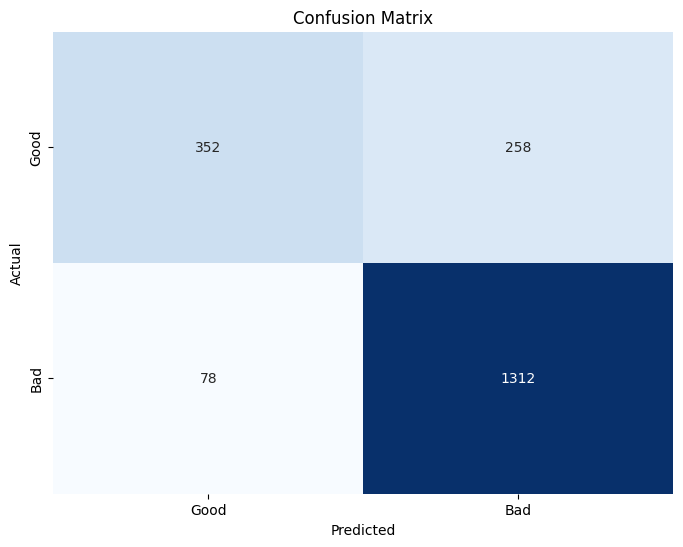

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
''' Les mauvais commentaires bien predits se trouve en bleu foncé sur la matrice.
    C'est l'intersection des deux colonnes bad.
    Il y a donc 1312 mauvais commentaires qui ont été bien prédit par le model.
    (Et 78 mauvais commentaires qui ont eté mal prédit).
'''

## Decision tree
Train a decision tree on `X_train_vecto` and `y_train`.

Please compare the accuracy scores of the training and test sets. Is there any overfitting? Are the scores better than previously?

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DTC = DecisionTreeClassifier(random_state=32)
DTC.fit(X_train_vecto, y_train)

DecisionTreeClassifier(random_state=32)

In [ ]:
y_train_pred_DTC = DTC.predict(X_train_vecto)
y_test_pred_DTC = DTC.predict(X_test_vecto)

In [ ]:
train_accuracy_DTC= accuracy_score(y_train, y_train_pred_DTC)
test_accuracy_DTC = accuracy_score(y_test, y_test_pred_DTC)

print(train_accuracy_DTC)
print(test_accuracy_DTC)

1.0
0.708


In [ ]:
''' L'ensemble d'entrainement obtient un score parfait de 1.0, soit il a parfaitement appris sur
    l'ensemble soit il fait de l'overfitting. Sur l'ensemble de test, la precision est significativement
    inférieure (0.708). Cela suggere que le modele sur l'ensemble d'entrainement ne se generalise pas bien sur
    l'ensemble de test. C'est un signe fort d'overfitting.
'''

In [ ]:
''' CONCLUSION :
    Au vu des résultats sur les ensembles d'entrainement et de test, il y a un
    overfitting fort dans le modèle DecisionTreeClassifier.
    La regression linéaire offre dans ce cas de bien meilleurs résultats dans les prédictions
    que l'arbre de decision. On pourrait par la suite essayer d'améliorer ces scores en ajustant les modeles.
'''

## Bonus question (optional)

Use `GridsearchCV` to find the best parameters.
Make sure you don't do more than 1000 different iterations (i.e. combinations).
Otherwise, the time may seem very long...





In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
''' limiter a 1000 > equivaut a 20 * 10 * 5 = 1000
    mise en place des paramètres à tester
'''

In [ ]:
parametre = {
    'max_depth': list(range(1, 21)),
    'min_samples_leaf': list(range(1, 6)),
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(DecisionTreeClassifier(), parametre, cv = 3, n_jobs=-1)


grid.fit(X_train_vecto, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
# Meilleurs paramètres trouvés par GridSearchCV
print(grid.best_params_)


{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [ ]:
# Prédiction
y_train_pred_grid = grid.predict(X_train_vecto)
y_test_pred_grid = grid.predict(X_test_vecto)

In [ ]:
train_accuracy_grid = accuracy_score(y_train, y_train_pred_grid)
test_accuracy_grid = accuracy_score(y_test, y_test_pred_grid)

print(train_accuracy_grid)
print(test_accuracy_grid)

0.8685
0.7255


In [ ]:
''' En augmentant le nombre d'itérations on arrive a avoir un score de prédiction plus précis,
    je pense qu'en augmentant encore il est possible de l'ameliorer, mais attention a l'overfitting,
    et mon pc ne supporterait pas plus (deja 12min pour 20*5*3 = 300 iterations)
    On constate aussi que le score sur l'ensemble d'entrainement ne fait plus d'overfitting par rapport
    au premier model
'''

# Optionnel : Algorithme `JSON` et manipulation.
This is a json file containing several keys.
Each key has a value, which could potentially be another key, containing another value, which could potentially be another key etc...

In [ ]:
food = {
  "clé1": {
    "fruit1": "pomme",
    "légume4": "brocoli"
  },
  "clé2": {
    "légume1": "carotte",
    "fruit5": "banane",
    "légume3": "courgette"
  },
  "clé3": {
    "niveau1": {
      "niveau2": {
        "fruit3": "orange",
        "légume5": "aubergine",
        "fruit5": "mangue"
      }
    }
  },
  "clé4": {
    "niveau1": {
      "niveau2": {
        "niveau3": {
          "fruit6": "raisin",
          "fruit7": "fraise",
          "légume4": "poivron",
          "fruit2": "pastèque"
        }
      }
    }
  }
}


Problem:
Fruits and vegetables have been misplaced in this json file. The goal is to retrieve each of the fruits and vegetables, and assign them to two corresponding lists: `fruits_list` & `vegetables_list`.

Expected solution:

`fruits_list` = `['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque']`

`vegetables_list` = `['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']`



In [ ]:

fruits_list = []
vegetables_list = []

def extract_items(data):
    if isinstance(data, dict):                                # Verifie si c'est un dict, sinon ne fait rien et passe
        for key, value in data.items():                       # Parcours chaque clé, valeur des dicts
            if key.startswith("fruit"):                       # si la clé commence par fruit
                  fruits_list.append(value)                   # on ajoute a la liste fruit
            elif key.startswith("légume"):                    # si la clé commence par un legume
                vegetables_list.append(value)                 # on ajoute a la liste legumes
            extract_items(value)                              # appel recursif pour les sous dictionnaire, permet de descendre d'un niveau a la recherche de dict
                                                              # jusqu'a ce que la fonction ai exploree tout les niveax

extract_items(food)

print('fruits_list = ', fruits_list)
print('vegetables_list = ', vegetables_list)

fruits_list =  ['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque']
vegetables_list =  ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']


Next, you'll create a new dictionary, which will simply contain two keys: `fruits` & `vegetables`. Each key will have the value of the list of fruits and the list of vegetables. That way, everything will be in order.

Expected solution:
`food_dict` = `{'fruits': ['pomme',
  'banane',
  'orange',
  'mangue',
  'raisin',
  'fraise',
  'pastèque'],
 'legumes': ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']}`

In [ ]:
food_dict = {
    'fruits': fruits_list,
    'legumes': vegetables_list
}

print(food_dict)

{'fruits': ['pomme', 'banane', 'orange', 'mangue', 'raisin', 'fraise', 'pastèque'], 'legumes': ['brocoli', 'carotte', 'courgette', 'aubergine', 'poivron']}
